# Agarose phantom analysis- using Waller lab code

We want to demonstrate phase-contrast OPT using the Tian and Waller WOTF model.

Using an agarose phantom (one cylinder embedded inside another, with different refractive indices).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import pickle

from dpc_algorithm import DPCSolver

## Reading in the images

In [2]:
# filepath on Predator machine
img_dir = r'D:\MSci_Project\1_Data\2023-03-17'
full_phantom = io.imread(img_dir + r'\2023-03-17 phase gradient phantom fullstack.tif')

# filepath on mac
# img_dir = '../../OPT Shared files/1_Data/2023-03-17/'
# phantom = io.imread(img_dir + '2023-03-17 phase gradient phantom fullstack.tif')
full_phantom = full_phantom.reshape((400,4,1392,1040)).astype('float32')

# with open('../report_plots/5_programmable/dpc-projections.pkl', 'rb') as f:
#     phantom = pickle.load(f)

Reshape into dimensions
* 400 (projections)
* 4 (illuminations)
* 1392 (height)
* 1040 (width)

In [5]:
im_width = 1040
im_height = 1392
e = 6.45e-3 # Pixel size (mm)

# Which projection to take
projection = 0

phantom = full_phantom[::100]

Process images by dividing by their background (Tian and Waller 2015).

We do background averaging.

In [6]:
# background_path = r'\2023-03-17 phase gradient background.tif'
background_path = '/2023-03-17 phase gradient background.tif'
background = io.imread(img_dir + background_path).astype('float32')[0:]

def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    # SIMILAR TO calibrations/lens_aperture.ipynb, but order is reversed
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(num_repeats, dim_0//num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=0)
    return output

background = get_averaged_stack(background, 5)
# np.max(background[4])
# plt.imshow(background.reshape(5,4, 1392, 1040)[2,0,:,:])

background.shape

(4, 1392, 1040)

In [7]:
phantom /= background

In [8]:
X, Y = np.meshgrid(np.arange(0,im_width)*e, np.arange(0,im_height)[::-1]*e, indexing='xy' )

0.20354788 2.8426595


Text(0.5, 0.98, 'Raw images divided by background')

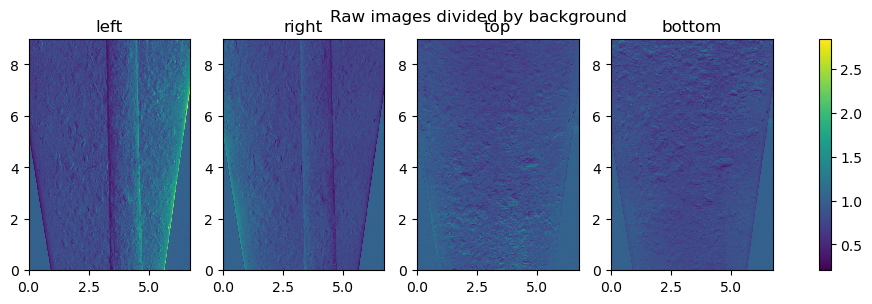

In [9]:
title_labels = ['left','right', 'top', 'bottom']
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phantom[projection])
vmax = np.max(phantom[projection])

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phantom[projection][i], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())

plt.suptitle('Raw images divided by background')

## Phase gradient

Use the indexing above to generate the illumination images, then pass into `plot_phase_gradient` to perform the necessary subtraction and integration. Optionally plot a row for debugging. 

Code is based off of (Tian and Waller 2015).

Initialise DPC solver

In [10]:
wavelength     =  0.650 #micron
mag            =   40
na             =   0.3 #numerical aperture
na_in          =    0.0
pixel_size_cam =    6.45 #pixel size of camera
dpc_num        =    4 #number of DPC images captured for each absorption and phase frame
pixel_size     = pixel_size_cam/mag
rotation       = [90, 270, 180, 0 ] #degree

In [11]:
dpc_images = phantom[0]

Visualsie source patterns

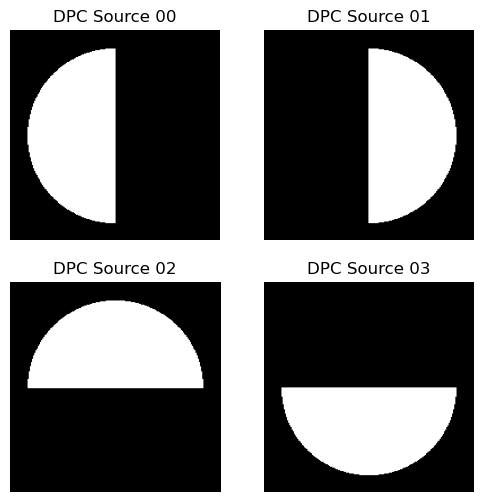

In [12]:
dpc_solver_obj = DPCSolver(dpc_images, wavelength, na, na_in, pixel_size, rotation, dpc_num=dpc_num)

#plot the sources
max_na_x = max(dpc_solver_obj.fxlin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
min_na_x = min(dpc_solver_obj.fxlin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
max_na_y = max(dpc_solver_obj.fylin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
min_na_y = min(dpc_solver_obj.fylin.real*dpc_solver_obj.wavelength/dpc_solver_obj.na)
f, ax  = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
for plot_index, source in enumerate(list(dpc_solver_obj.source)):
    plot_row = plot_index//2
    plot_col = np.mod(plot_index, 2)
    ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.source[plot_index]),\
                                  cmap='gray', clim=(0,1), extent=[min_na_x, max_na_x, min_na_y, max_na_y])
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_title("DPC Source {:02d}".format(plot_index))
    ax[plot_row, plot_col].set_xlim(-1.2, 1.2)
    ax[plot_row, plot_col].set_ylim(-1.2, 1.2)
    ax[plot_row, plot_col].set_aspect(1)

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

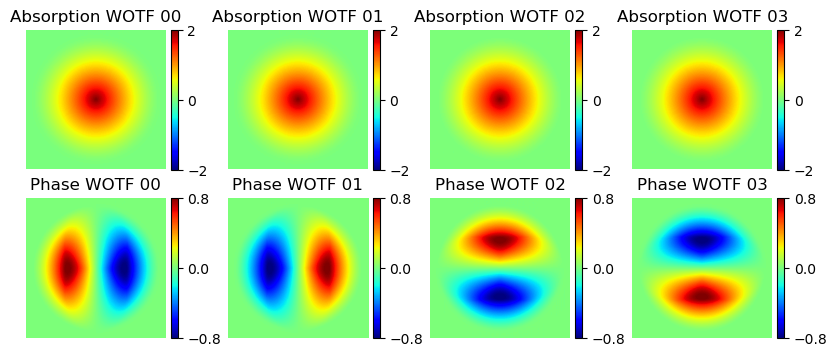

In [14]:
#plot the transfer functions
f, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize = (10, 4))
for plot_index in range(ax.size):
    plot_row = plot_index//4
    plot_col = np.mod(plot_index, 4)
    divider  = make_axes_locatable(ax[plot_row, plot_col])
    cax      = divider.append_axes("right", size="5%", pad=0.05)
    if plot_row == 0:
        plot = ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.Hu[plot_col].real), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=[-2., 2.])
        ax[plot_row, plot_col].set_title("Absorption WOTF {:02d}".format(plot_col))
        plt.colorbar(plot, cax=cax, ticks=[-2., 0, 2.])
    else:
        plot = ax[plot_row, plot_col].imshow(np.fft.fftshift(dpc_solver_obj.Hp[plot_col].imag), cmap='jet',\
                                             extent=[min_na_x, max_na_x, min_na_y, max_na_y], clim=[-.8, .8])
        ax[plot_row, plot_col].set_title("Phase WOTF {:02d}".format(plot_col))
        plt.colorbar(plot, cax=cax, ticks=[-.8, 0, .8])
    ax[plot_row, plot_col].set_xlim(-2.2, 2.2)
    ax[plot_row, plot_col].set_ylim(-2.2, 2.2)
    ax[plot_row, plot_col].axis("off")
    ax[plot_row, plot_col].set_aspect(1)

In [15]:
#parameters for Tikhonov regurlarization [absorption, phase] ((need to tune this based on SNR)
dpc_solver_obj.setTikhonovRegularization(reg_u = 1e-1, reg_p = 5e-3)
dpc_result = dpc_solver_obj.solve()

Text(0.5, 1.0, 'Phase')

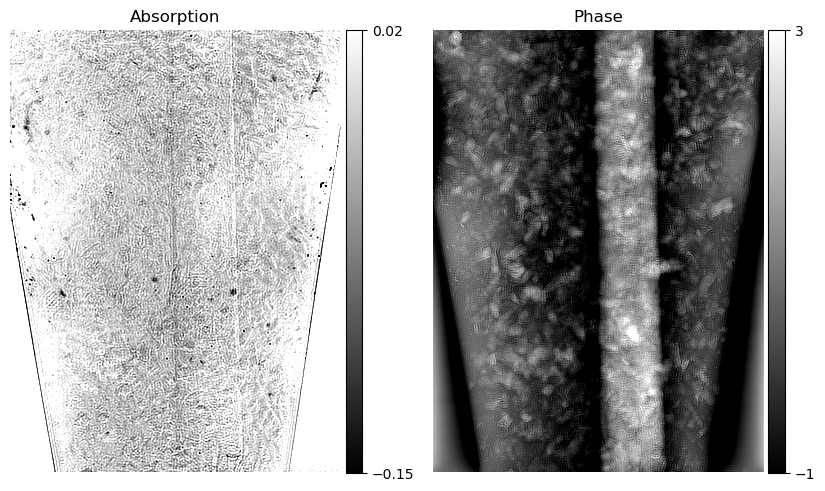

In [16]:
_, axes  = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
divider  = make_axes_locatable(axes[0])
cax_1    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[0].imshow(dpc_result[0].real, clim=[-0.15, 0.02], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[0].axis("off")
plt.colorbar(plot, cax=cax_1, ticks=[-0.15, 0.02])
axes[0].set_title("Absorption")
divider  = make_axes_locatable(axes[1])
cax_2    = divider.append_axes("right", size="5%", pad=0.05)
plot     = axes[1].imshow(dpc_result[0].imag, clim=[-1.0, 3.0], cmap="gray", extent=[0, dpc_result[0].shape[-1], 0, dpc_result[0].shape[-2]])
axes[1].axis("off")
plt.colorbar(plot, cax=cax_2, ticks=[-1, 3])
axes[1].set_title("Phase")

Now altogether, do it for all the projections

In [38]:
def do_dpc(dpc_images):
    dpc_solver_obj = DPCSolver(dpc_images, wavelength, na, na_in, pixel_size, rotation, dpc_num=dpc_num)
    dpc_solver_obj.setTikhonovRegularization(reg_u = 1e-1, reg_p = 5)
    dpc_result = dpc_solver_obj.solve()
    return dpc_result[0].imag

num_projections = len(phantom)
phase_contrast = np.zeros((num_projections, im_height, im_width))

for i in tqdm(range(num_projections)):
    phi = do_dpc(phantom[i])
    phase_contrast[i] = phi

100%|██████████| 4/4 [00:16<00:00,  4.01s/it]


-0.18707567233000907 0.16766612584297982


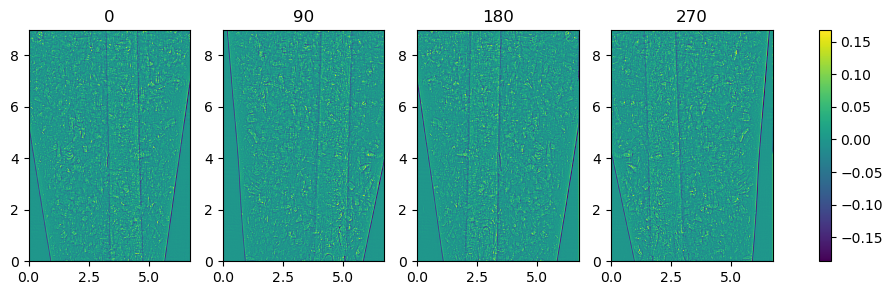

In [39]:
title_labels = [0, 90, 180, 270]
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phase_contrast)
vmax = np.max(phase_contrast)

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phase_contrast[i], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())


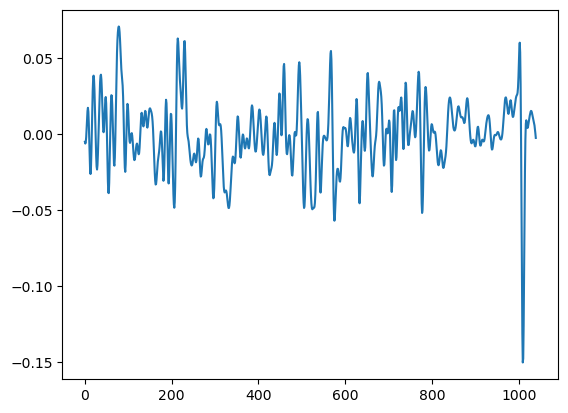

In [40]:
plt.plot(phase_contrast[0, 500,:].T)

Some diagnosing --> mean fluctuates in successsive OPT projections

In [17]:
angles = np.linspace(0, 360, num_projections, endpoint=False)

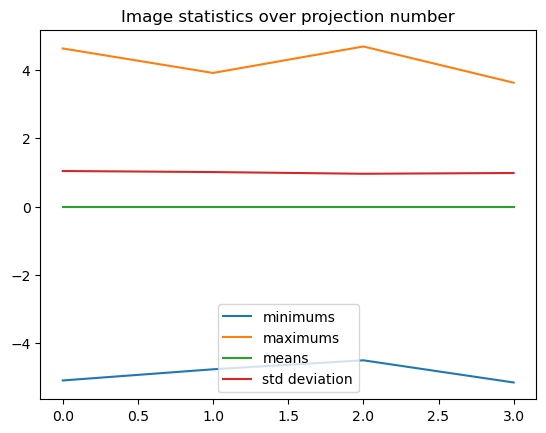

In [18]:
minimums = []
maximums = []
means = []
std = [] 
for i in range(num_projections):
    minimums.append(np.min(phase_contrast[i]))
    maximums.append(np.max(phase_contrast[i]))
    means.append(np.mean(phase_contrast[i]))
    std.append(np.std(phase_contrast[i]))

plt.title('Image statistics over projection number')
plt.plot(minimums, label='minimums')
plt.plot(maximums, label= 'maximums')
plt.plot(means, label='means')


plt.plot(std, label='std deviation')
plt.legend()
plt.show()

In [19]:
num_projections = len(full_phantom)
phase_contrast = np.zeros((num_projections, im_height, im_width))

for i in tqdm(range(num_projections)):
    phase_contrast[i] = do_dpc(full_phantom[i])

100%|██████████| 400/400 [27:21<00:00,  4.10s/it]


In [27]:
import pickle
with open('2023-04-10 agarose-phantom-waller.pkl', 'wb') as f:
    pickle.dump(phase_contrast, f)

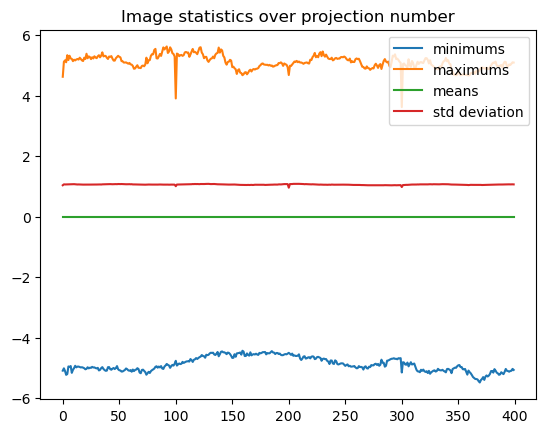

In [20]:
minimums = []
maximums = []
means = []
std = [] 
for i in range(num_projections):
    minimums.append(np.min(phase_contrast[i]))
    maximums.append(np.max(phase_contrast[i]))
    means.append(np.mean(phase_contrast[i]))
    std.append(np.std(phase_contrast[i]))

plt.title('Image statistics over projection number')
plt.plot(minimums, label='minimums')
plt.plot(maximums, label= 'maximums')
plt.plot(means, label='means')


plt.plot(std, label='std deviation')
plt.legend()
plt.show()

Arbitrary scaling for future saving as integers.

In [21]:
bias = 2e4
scale = 2000
phase_contrast_processed = phase_contrast*scale + bias

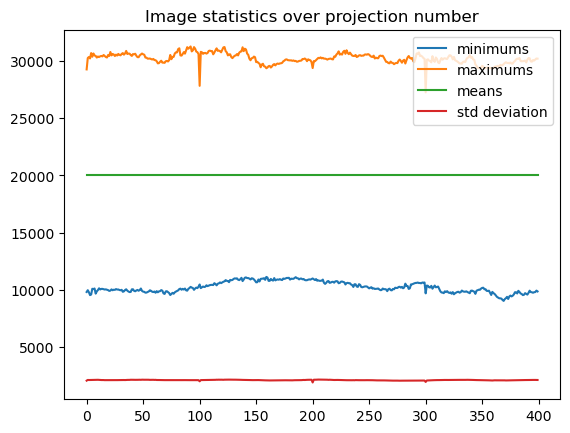

In [22]:
def plot_statistics(array):
    minimums = []
    maximums = []
    means = []
    std = [] 
    for i in range(num_projections):
        minimums.append(np.min(array[i]))
        maximums.append(np.max(array[i]))
        means.append(np.mean(array[i]))
        std.append(np.std(array[i]))

    plt.title('Image statistics over projection number')
    plt.plot(minimums, label='minimums')
    plt.plot(maximums, label= 'maximums')
    plt.plot(means, label='means')
    
    plt.plot(std, label='std deviation')
    plt.legend()
    plt.show()

plot_statistics(phase_contrast_processed)

9039.49279667001 31255.305043592514


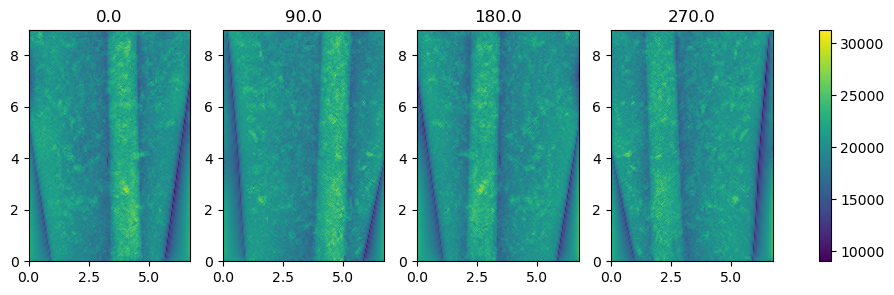

In [23]:
angles = np.linspace(0, 360, 400, endpoint=False)
indices = [0, 100, 200, 300]
title_labels = angles[indices]
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phase_contrast_processed)
vmax = np.max(phase_contrast_processed)

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phase_contrast_processed[indices[i]], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())


Save as tiff

In [24]:
io.imsave('2023-04-29 phase_contrast_waller.tiff', ( phase_contrast_processed).astype('uint16'))